## Введение в искусственные нейронные сети
### Урок 5. Рекуррентные нейронные сети

1. Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
from datetime import datetime

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [2]:
tf.config.list_physical_devices('GPU')

[]

## Загрузка, предварительный анализ и подготовка данных. 

### Загрузка и визуальный анализ 

In [3]:
# Загрузка датасета
airline_passengers_df = pd.read_csv('airline-passengers.csv',engine='python', skipfooter=5)
print(airline_passengers_df.keys())

Index(['Month', 'Passengers'], dtype='object')


In [4]:
# Визуальный анализ набора 
airline_passengers_df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
airline_passengers_df.tail()

,Month,Passengers
134,1960-03,419
135,1960-04,461
136,1960-05,472
137,1960-06,535
138,1960-07,622


In [6]:
# Быстрый анализ типов данных и наличия пропусков 
airline_passengers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       139 non-null    object
 1   Passengers  139 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


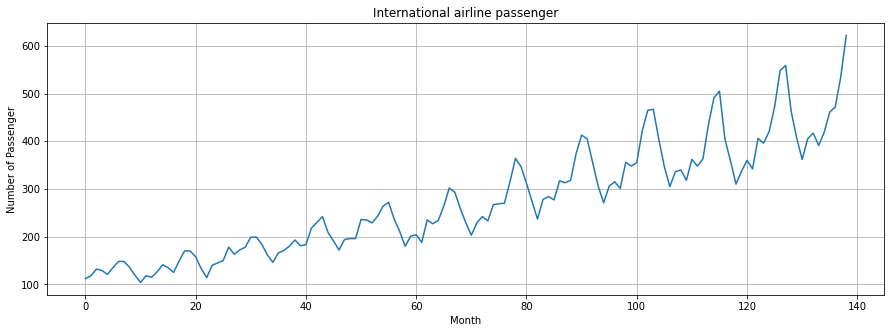

In [7]:
# Визуальный анализ набора 
airline_passengers_df = airline_passengers_df.iloc[:,1].values
plt.figure(figsize=(15,5))
plt.grid('on')
plt.plot(airline_passengers_df)
plt.xlabel("Month")
plt.ylabel("Number of Passenger")
plt.title("International airline passenger")
plt.show()

### Нормализация данных 

In [8]:
#Изменение формы дынных
airline_passengers_df = airline_passengers_df.reshape(-1,1)
airline_passengers_df = airline_passengers_df.astype("float32")
airline_passengers_df.shape

(139, 1)

In [9]:
# Масштабирование  
scaler = MinMaxScaler(feature_range=(0, 1))
airline_passengers_df_sc = scaler.fit_transform(airline_passengers_df)

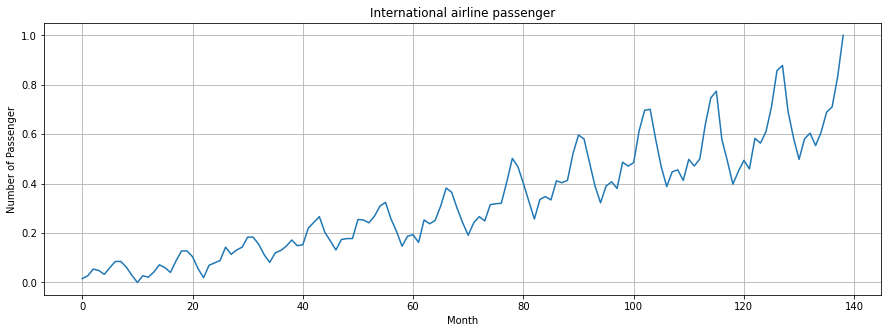

In [10]:
# Визуальный анализ набора после масштбирования 
plt.figure(figsize=(15,5))
plt.grid('on')
plt.plot(airline_passengers_df_sc)
plt.xlabel("Month")
plt.ylabel("Number of Passenger")
plt.title("International airline passenger")
plt.show()
plt.show()

### Подготовка данных

In [11]:
dataset = airline_passengers_df
dataset_scaled = airline_passengers_df_sc

In [12]:
train_size = int(len(dataset) * 0.60)
test_size = len(dataset) - train_size
train = dataset_scaled[0:train_size,:]
test = dataset_scaled[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 83, test size: 56 


In [13]:
timestemp = 10
dataX = []
dataY = []
for i in range(len(train)-timestemp-1):
    a = train[i:(i+timestemp), 0]
    dataX.append(a)
    dataY.append(train[i + timestemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)  

In [14]:
dataX = []
dataY = []
for i in range(len(test)-timestemp-1):
    a = test[i:(i+timestemp), 0]
    dataX.append(a)
    dataY.append(test[i + timestemp, 0])
testX = np.array(dataX)
testY = np.array(dataY) 

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print('shape of trainX: ', trainX.shape)
print('shape of testX: ', testX.shape)

shape of trainX:  (72, 10, 1)
shape of testX:  (45, 10, 1)


## Создание моделей нейронныйх сетей 

### RNN

Model: "rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10, 100)           10200     
_________________________________________________________________
dropout (Dropout)            (None, 10, 100)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10, 80)            14480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 50)            6550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 50)            0     

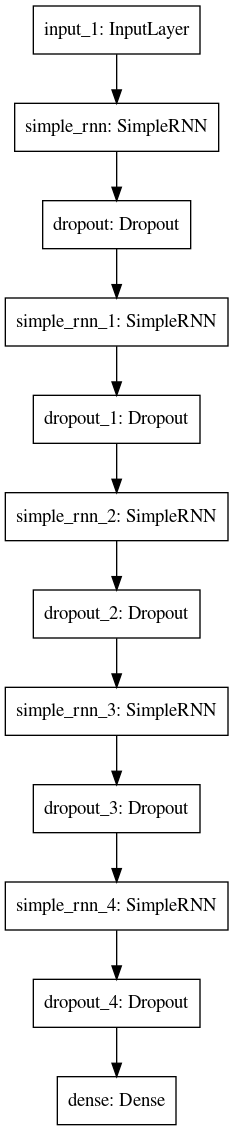

In [16]:
# Входные данные модели 
model_input = Input(shape=(trainX.shape[1], 1))

# БЛОК 1: Рекурентные слои 
# Слой #1
x = SimpleRNN(100,activation='relu', return_sequences = True)(model_input)
x = Dropout(0.25)(x)
# Слой #2
x = SimpleRNN(80,activation='relu', return_sequences = True)(x)
x = Dropout(0.25)(x)
# Слой #3
x = SimpleRNN(50,activation='relu', return_sequences = True)(x)
x = Dropout(0.25)(x)
# Слой #4
x = SimpleRNN(30,activation='relu', return_sequences = True)(x)
x = Dropout(0.25)(x)
# Слой #5
x = SimpleRNN(units = 20)(x)
x = Dropout(0.25)(x)

# БЛОК 2: Полносвязанный слой 
x = Dense(1)(x)

# Создание модели 
model_1 = Model(model_input, x, name='rnn_1')

# Компиляция модели
model_1.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mae'])


model_1.summary()
keras.utils.plot_model(model_1, "model.png")

In [17]:
history_1 = model_1.fit(trainX, trainY, 
                        batch_size=1,
                        epochs=155, 
                        verbose=2,
                        validation_data=(testX, testY))

Epoch 1/155
72/72 - 3s - loss: 0.0336 - mae: 0.1302 - val_loss: 0.0509 - val_mae: 0.1868
Epoch 2/155
72/72 - 1s - loss: 0.0118 - mae: 0.0808 - val_loss: 0.0513 - val_mae: 0.1896
Epoch 3/155
72/72 - 1s - loss: 0.0136 - mae: 0.0882 - val_loss: 0.0213 - val_mae: 0.1018
Epoch 4/155
72/72 - 1s - loss: 0.0119 - mae: 0.0851 - val_loss: 0.0212 - val_mae: 0.1036
Epoch 5/155
72/72 - 1s - loss: 0.0085 - mae: 0.0716 - val_loss: 0.0153 - val_mae: 0.1044
Epoch 6/155
72/72 - 1s - loss: 0.0095 - mae: 0.0764 - val_loss: 0.0357 - val_mae: 0.1550
Epoch 7/155
72/72 - 1s - loss: 0.0083 - mae: 0.0689 - val_loss: 0.0285 - val_mae: 0.1299
Epoch 8/155
72/72 - 1s - loss: 0.0090 - mae: 0.0692 - val_loss: 0.0306 - val_mae: 0.1384
Epoch 9/155
72/72 - 1s - loss: 0.0083 - mae: 0.0730 - val_loss: 0.0185 - val_mae: 0.0990
Epoch 10/155
72/72 - 1s - loss: 0.0060 - mae: 0.0623 - val_loss: 0.0160 - val_mae: 0.1119
Epoch 11/155
72/72 - 1s - loss: 0.0081 - mae: 0.0706 - val_loss: 0.0111 - val_mae: 0.0804
Epoch 12/155
72/72 

## Оценка результатов 

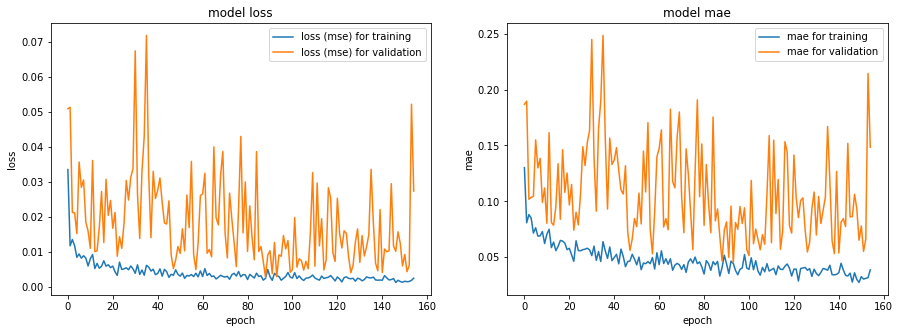

In [18]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15, 5))
axL.plot(history_1.history['loss'], label="loss (mse) for training")
axL.plot(history_1.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(history_1.history['mae'], label="mae for training")
axR.plot(history_1.history['val_mae'], label="mae for validation")
axR.set_title('model mae')
axR.set_xlabel('epoch')
axR.set_ylabel('mae')
axR.legend(loc='upper right')

plt.show()

In [19]:
trainPredict = model_1.predict(trainX)
testPredict = model_1.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 18.30 RMSE
Test Score: 85.79 RMSE


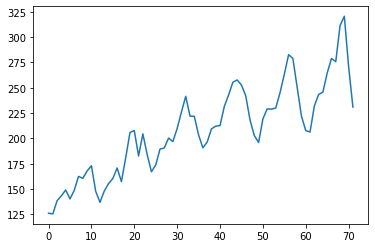

In [20]:
plt.plot(trainPredict)

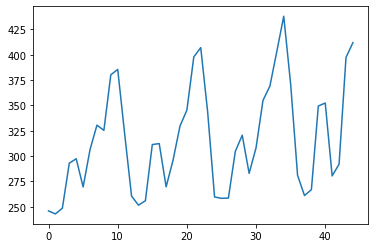

In [21]:
plt.plot(testPredict)

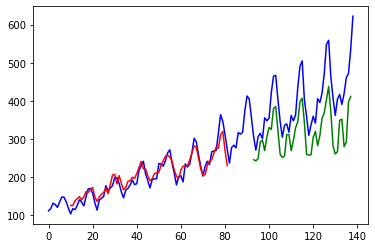

In [22]:
# shifting train
trainPredictPlot = np.empty_like(airline_passengers_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[timestemp:len(trainPredict)+timestemp, :] = trainPredict

# shifting test predictions for plotting
testPredictPlot = np.empty_like(airline_passengers_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(timestemp*2)+1:len(airline_passengers_df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(airline_passengers_df_sc), color='b')
plt.plot(trainPredictPlot, color='r')
plt.plot(testPredictPlot, color='g')
plt.show()

### LSTM 

In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [24]:
train_size = int(len(dataset)*0.50)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print('train_size : {}, test_size : {}'.format(len(train),len(test)))

train_size : 69, test_size : 70


In [25]:
timestamp=10
dataX = []
dataY = []
for i in range(len(train)-timestamp-1):
    a = train[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(train[i+timestamp,0])
trainX = np.array(dataX)
trainY = np.array(dataY)

In [26]:
timestep=10
dataX = []
dataY = []
for i in range(len(test)-timestamp-1):
    a = test[i:(i+timestamp),0]
    dataX.append(a)
    dataY.append(test[i+timestamp,0])
testX = np.array(dataX)
testY = np.array(dataY)

In [27]:
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

Model: "rnn_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 10)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                840       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________


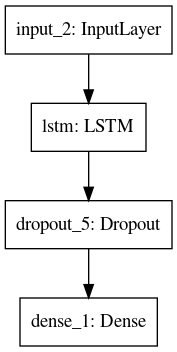

In [28]:
# Входные данные модели 
model_input = Input(shape=(1, timestemp))

# БЛОК 1: Рекурентные слои 
# Слой #1
x = LSTM(10,activation='relu')(model_input)
x = Dropout(0.25)(x)

# БЛОК 2: Полносвязанный слой 
x = Dense(1)(x)

# Создание модели 
model_2 = Model(model_input, x, name='rnn_2')

# Компиляция модели
model_2.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mae'])


model_2.summary()
keras.utils.plot_model(model_2, "model.png")

In [29]:
history_2 = model_2.fit(trainX, trainY, 
                        batch_size=1,
                        epochs=155, 
                        verbose=2,
                        validation_data=(testX, testY))

Epoch 1/155
58/58 - 1s - loss: 0.0205 - mae: 0.1174 - val_loss: 0.1402 - val_mae: 0.3501
Epoch 2/155
58/58 - 0s - loss: 0.0093 - mae: 0.0723 - val_loss: 0.0722 - val_mae: 0.2357
Epoch 3/155
58/58 - 0s - loss: 0.0076 - mae: 0.0661 - val_loss: 0.0442 - val_mae: 0.1685
Epoch 4/155
58/58 - 0s - loss: 0.0049 - mae: 0.0572 - val_loss: 0.0387 - val_mae: 0.1542
Epoch 5/155
58/58 - 0s - loss: 0.0048 - mae: 0.0567 - val_loss: 0.0338 - val_mae: 0.1402
Epoch 6/155
58/58 - 0s - loss: 0.0053 - mae: 0.0584 - val_loss: 0.0356 - val_mae: 0.1465
Epoch 7/155
58/58 - 0s - loss: 0.0053 - mae: 0.0589 - val_loss: 0.0312 - val_mae: 0.1336
Epoch 8/155
58/58 - 0s - loss: 0.0046 - mae: 0.0491 - val_loss: 0.0258 - val_mae: 0.1155
Epoch 9/155
58/58 - 0s - loss: 0.0046 - mae: 0.0529 - val_loss: 0.0210 - val_mae: 0.1014
Epoch 10/155
58/58 - 0s - loss: 0.0052 - mae: 0.0585 - val_loss: 0.0224 - val_mae: 0.1053
Epoch 11/155
58/58 - 0s - loss: 0.0056 - mae: 0.0578 - val_loss: 0.0251 - val_mae: 0.1161
Epoch 12/155
58/58 

## Оценка результатов 

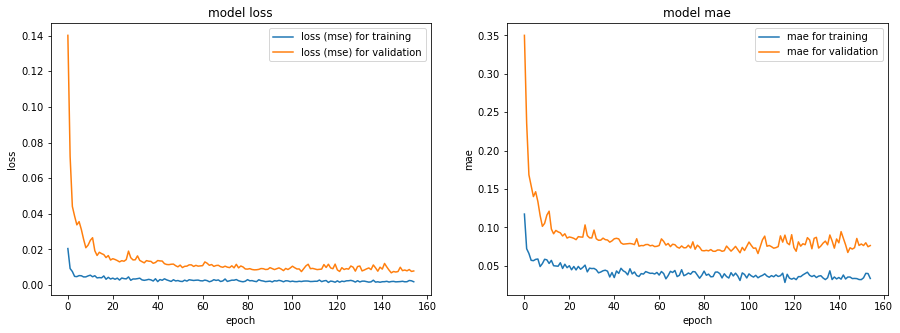

In [30]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15, 5))
axL.plot(history_2.history['loss'], label="loss (mse) for training")
axL.plot(history_2.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(history_2.history['mae'], label="mae for training")
axR.plot(history_2.history['val_mae'], label="mae for validation")
axR.set_title('model mae')
axR.set_xlabel('epoch')
axR.set_ylabel('mae')
axR.legend(loc='upper right')

plt.show()

In [31]:
trainPredict = model_2.predict(trainX)
testPredict = model_2.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.96 RMSE
Test Score: 46.20 RMSE


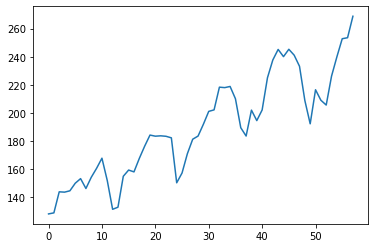

In [32]:
plt.plot(trainPredict)

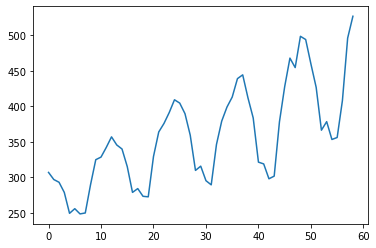

In [33]:
plt.plot(testPredict)

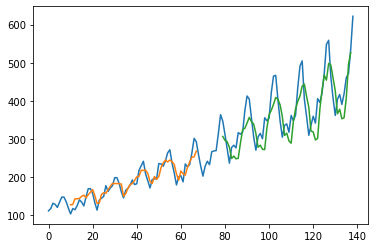

In [34]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[timestamp:len(trainPredict)+timestamp, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(timestamp*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### GRU

Model: "rnn_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 10)]           0         
_________________________________________________________________
gru_12 (GRU)                 (None, 1, 128)            53760     
_________________________________________________________________
gru_13 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 91,073
Trainable params: 91,073
Non-trainable params: 0
_________________________________________________________________


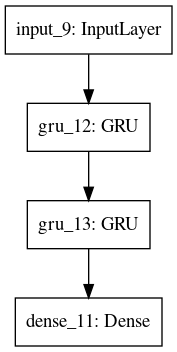

In [58]:
# Входные данные модели 
model_input = Input(shape=(1, 10,))

# БЛОК 1: Рекурентные слои 
# Слой #1
x = GRU(128, return_sequences=True)(model_input)

# Слой #2
x = GRU(64)(x)

# БЛОК 2: Полносвязанный слой 
x = Dense(1)(x)

# Создание модели 
model_3 = Model(model_input, x, name='rnn_3')

# Компиляция модели
model_3.compile(loss='mse', 
                optimizer='adam', 
                metrics=['mae'])


model_3.summary()
keras.utils.plot_model(model_3, "model.png")

In [59]:
history_3 = model_3.fit(trainX, trainY, 
                        batch_size=1,
                        epochs=5, 
                        verbose=2,
                        validation_data=(testX, testY))

ValueError: Data cardinality is ambiguous:
  x sizes: 58
  y sizes: 1
Make sure all arrays contain the same number of samples.

## Оценка результатов 

In [ ]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15, 5))
axL.plot(history_3.history['loss'], label="loss (mse) for training")
axL.plot(history_3.history['val_loss'], label="loss (mse) for validation")
axL.set_title('model loss')
axL.set_xlabel('epoch')
axL.set_ylabel('loss')
axL.legend(loc='upper right')

axR.plot(history_3.history['mae'], label="mae for training")
axR.plot(history_3.history['val_mae'], label="mae for validation")
axR.set_title('model mae')
axR.set_xlabel('epoch')
axR.set_ylabel('mae')
axR.legend(loc='upper right')

plt.show()

In [ ]:
trainPredict = model_3.predict(trainX)
testPredict = model_3.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
plt.plot(trainPredict)

In [ ]:
plt.plot(testPredict)

In [ ]:
# shifting train
trainPredictPlot = np.empty_like(airline_passengers_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[timestamp:len(trainPredict)+timestamp, :] = trainPredict

# shifting test predictions for plotting
testPredictPlot = np.empty_like(airline_passengers_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(timestamp*2)+1:len(airline_passengers_df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(airline_passengers_df_sc), color='b')
plt.plot(trainPredictPlot, color='r')
plt.plot(testPredictPlot, color='g')
plt.show()